In [29]:
import os
import cv2
import numpy as np
from PIL import Image, ImageFilter
import warnings
from tqdm import tqdm
import time
import json
from collections import Counter
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [30]:
class DatasetAnalyzer:
    """데이터셋 특성 분석기"""
    
    def __init__(self, 
                 rotation_threshold_min=0.5,
                 rotation_threshold_max=15.0,
                 noise_threshold=20.0):
        
        self.rotation_threshold_min = rotation_threshold_min
        self.rotation_threshold_max = rotation_threshold_max
        self.noise_threshold = noise_threshold
    
    def analyze_noise_level(self, image):
        """이미지 노이즈 수준 분석"""
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            # 가우시안 블러로 신호 분리
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            
            # 노이즈 추정 (원본 - 블러)
            noise = gray.astype(np.float32) - blurred.astype(np.float32)
            
            # 노이즈 강도 계산
            noise_std = np.std(noise)
            noise_mean = np.mean(np.abs(noise))
            
            # 엣지 밀도 (선명도 지표)
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / edges.size
            
            # 종합 노이즈 점수 계산
            noise_score = noise_std + (noise_mean * 2)
            
            is_noisy = noise_score > self.noise_threshold
            
            return {
                "noise_score": noise_score,
                "noise_std": noise_std,
                "noise_mean": noise_mean,
                "edge_density": edge_density,
                "is_very_noisy": is_noisy,
                "noise_level": "high" if is_noisy else "normal"
            }
            
        except Exception as e:
            return {
                "noise_score": 0,
                "noise_std": 0,
                "noise_mean": 0,
                "edge_density": 0,
                "is_very_noisy": False,
                "noise_level": "unknown",
                "error": str(e)
            }
    
    def analyze_rotation_needed(self, image):
        """회전 필요성 분석"""
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            edges = cv2.Canny(gray, 50, 150, apertureSize=3)
            edge_count = np.sum(edges > 0)
            
            if edge_count < 100:
                return False, 0, f"엣지 부족 ({edge_count})"
            
            lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=80)
            
            if lines is None or len(lines) < 3:
                return False, 0, f"직선 부족 ({len(lines) if lines is not None else 0})"
            
            angles = []
            for rho, theta in lines[:min(20, len(lines)), 0]:
                angle_deg = theta * 180 / np.pi
                if angle_deg < 45 or angle_deg > 135:
                    if angle_deg > 90:
                        angles.append(angle_deg - 180)
                    else:
                        angles.append(angle_deg)
            
            if len(angles) < 3:
                return False, 0, f"유효 각도 부족 ({len(angles)})"
            
            rotation_angle = np.median(angles)
            angle_std = np.std(angles)
            
            if angle_std > 10:
                return False, rotation_angle, f"각도 분산 큼 ({angle_std:.1f})"
            
            if abs(rotation_angle) >= self.rotation_threshold_min and abs(rotation_angle) <= self.rotation_threshold_max:
                return True, rotation_angle, f"회전 필요 (신뢰도: {len(angles)}, 분산: {angle_std:.1f})"
            else:
                return False, rotation_angle, f"임계값 밖 ({abs(rotation_angle):.1f}도)"
                
        except Exception as e:
            return False, 0, f"분석 오류: {e}"
    
    def analyze_dataset_characteristics(self, input_dir, sample_size=200):
        """데이터셋 전체 특성 분석"""
        
        print("🔍 데이터셋 특성 분석")
        print("=" * 50)
        
        # 이미지 파일 목록
        image_files = [f for f in os.listdir(input_dir) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        
        if not image_files:
            print("❌ 이미지 파일을 찾을 수 없습니다.")
            return None
        
        if len(image_files) > sample_size:
            # 균등하게 샘플링
            step = len(image_files) // sample_size
            sample_files = image_files[::step][:sample_size]
        else:
            sample_files = image_files
        
        print(f"📊 전체 이미지: {len(image_files)}개")
        print(f"📊 분석 대상: {len(sample_files)}개 (샘플링)")
        
        # 결과 저장
        analysis_results = {
            "dataset_info": {
                "total_images": len(image_files),
                "analyzed_samples": len(sample_files),
                "analysis_ratio": len(sample_files) / len(image_files)
            },
            "rotation_stats": {
                "need_rotation": 0, 
                "no_rotation": 0, 
                "angles": [], 
                "reasons": []
            },
            "noise_stats": {
                "high_noise": 0, 
                "normal_noise": 0, 
                "scores": [], 
                "levels": []
            },
            "details": []
        }
        
        print(f"\n🔄 특성 분석 중...")
        failed_count = 0
        
        for img_file in tqdm(sample_files):
            try:
                img_path = os.path.join(input_dir, img_file)
                image = cv2.imread(img_path)
                
                if image is None:
                    # PIL로 재시도
                    try:
                        pil_image = Image.open(img_path).convert('RGB')
                        image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
                    except:
                        failed_count += 1
                        continue
                
                if image is None:
                    failed_count += 1
                    continue
                
                # 회전 분석
                needs_rotation, angle, rotation_reason = self.analyze_rotation_needed(image)
                if needs_rotation:
                    analysis_results["rotation_stats"]["need_rotation"] += 1
                    analysis_results["rotation_stats"]["angles"].append(angle)
                else:
                    analysis_results["rotation_stats"]["no_rotation"] += 1
                analysis_results["rotation_stats"]["reasons"].append(rotation_reason)
                
                # 노이즈 분석
                noise_analysis = self.analyze_noise_level(image)
                if noise_analysis["is_very_noisy"]:
                    analysis_results["noise_stats"]["high_noise"] += 1
                else:
                    analysis_results["noise_stats"]["normal_noise"] += 1
                
                analysis_results["noise_stats"]["scores"].append(noise_analysis["noise_score"])
                analysis_results["noise_stats"]["levels"].append(noise_analysis["noise_level"])
                
                # 상세 정보
                analysis_results["details"].append({
                    "filename": img_file,
                    "needs_rotation": needs_rotation,
                    "rotation_angle": angle,
                    "rotation_reason": rotation_reason,
                    "noise_level": noise_analysis["noise_level"],
                    "noise_score": noise_analysis["noise_score"],
                    "is_very_noisy": noise_analysis["is_very_noisy"]
                })
                
            except Exception as e:
                failed_count += 1
                if failed_count <= 10:  # 처음 10개 오류만 출력
                    print(f"\n⚠️ {img_file} 분석 오류: {e}")
        
        if failed_count > 0:
            print(f"\n⚠️ {failed_count}개 이미지 분석 실패")
        
        # 결과 출력
        self.print_analysis_results(analysis_results)
        
        # 결과 저장
        self.save_analysis_results(analysis_results, input_dir)
        
        return analysis_results
    
    def print_analysis_results(self, results):
        """분석 결과 출력"""
        rotation_stats = results["rotation_stats"]
        noise_stats = results["noise_stats"]
        
        rotation_total = rotation_stats["need_rotation"] + rotation_stats["no_rotation"]
        noise_total = noise_stats["high_noise"] + noise_stats["normal_noise"]
        
        print(f"\n📈 회전 분석 결과:")
        if rotation_total > 0:
            print(f"   • 회전 필요: {rotation_stats['need_rotation']} ({rotation_stats['need_rotation']/rotation_total*100:.1f}%)")
            print(f"   • 회전 불필요: {rotation_stats['no_rotation']} ({rotation_stats['no_rotation']/rotation_total*100:.1f}%)")
            
            if rotation_stats["angles"]:
                angles = rotation_stats["angles"]
                print(f"   • 평균 회전 각도: {np.mean(angles):.2f}도")
                print(f"   • 회전 각도 범위: {min(angles):.2f}도 ~ {max(angles):.2f}도")
        
        print(f"\n📈 노이즈 분석 결과:")
        if noise_total > 0:
            print(f"   • 고노이즈: {noise_stats['high_noise']} ({noise_stats['high_noise']/noise_total*100:.1f}%)")
            print(f"   • 일반 노이즈: {noise_stats['normal_noise']} ({noise_stats['normal_noise']/noise_total*100:.1f}%)")
            
            if noise_stats["scores"]:
                scores = noise_stats["scores"]
                print(f"   • 평균 노이즈 점수: {np.mean(scores):.2f}")
                print(f"   • 노이즈 점수 범위: {min(scores):.2f} ~ {max(scores):.2f}")
        
        # 회전 이유별 통계 (상위 10개만)
        print(f"\n📝 회전 판단 이유 (상위 10개):")
        reason_counts = Counter(rotation_stats["reasons"])
        for reason, count in reason_counts.most_common(10):
            print(f"   • {reason}: {count}회")
        
        # 권장 사항
        if rotation_total > 0 and noise_total > 0:
            rotation_pct = rotation_stats['need_rotation'] / rotation_total * 100
            noise_pct = noise_stats['high_noise'] / noise_total * 100
            
            print(f"\n💡 처리 권장 사항:")
            print(f"   • 회전 보정: {'활성화 권장' if rotation_pct > 20 else '선택 사항'} ({rotation_pct:.1f}%)")
            print(f"   • 강화 노이즈 제거: {'활성화 권장' if noise_pct > 15 else '선택 사항'} ({noise_pct:.1f}%)")
            
            if rotation_pct > 30:
                print(f"   ✅ 회전 보정이 효과적일 것으로 예상됩니다.")
            if noise_pct > 20:
                print(f"   ✅ 강화 노이즈 제거가 효과적일 것으로 예상됩니다.")
    
    def save_analysis_results(self, results, input_dir):
        """분석 결과를 JSON 파일로 저장"""
        try:
            # 저장 경로 설정
            base_dir = os.path.dirname(input_dir)
            save_path = os.path.join(base_dir, "dataset_analysis_results.json")
            
            # JSON으로 저장
            with open(save_path, 'w', encoding='utf-8') as f:
                json.dump(results, f, indent=2, ensure_ascii=False)
            
            print(f"\n💾 분석 결과 저장: {save_path}")
            print(f"   파일 크기: {os.path.getsize(save_path) / 1024:.1f} KB")
            
            # 요약 정보도 별도 저장
            summary = {
                "dataset_summary": {
                    "total_images": results["dataset_info"]["total_images"],
                    "rotation_needed_percentage": results["rotation_stats"]["need_rotation"] / (results["rotation_stats"]["need_rotation"] + results["rotation_stats"]["no_rotation"]) * 100,
                    "high_noise_percentage": results["noise_stats"]["high_noise"] / (results["noise_stats"]["high_noise"] + results["noise_stats"]["normal_noise"]) * 100,
                    "avg_rotation_angle": np.mean(results["rotation_stats"]["angles"]) if results["rotation_stats"]["angles"] else 0,
                    "avg_noise_score": np.mean(results["noise_stats"]["scores"]) if results["noise_stats"]["scores"] else 0
                },
                "recommendations": {
                    "enable_rotation": results["rotation_stats"]["need_rotation"] / (results["rotation_stats"]["need_rotation"] + results["rotation_stats"]["no_rotation"]) > 0.2,
                    "enable_heavy_noise_correction": results["noise_stats"]["high_noise"] / (results["noise_stats"]["high_noise"] + results["noise_stats"]["normal_noise"]) > 0.15
                }
            }
            
            summary_path = os.path.join(base_dir, "dataset_analysis_summary.json")
            with open(summary_path, 'w', encoding='utf-8') as f:
                json.dump(summary, f, indent=2, ensure_ascii=False)
            
            print(f"📋 분석 요약 저장: {summary_path}")
            
        except Exception as e:
            print(f"⚠️ 결과 저장 중 오류: {e}")


In [32]:
def main():
    """메인 실행 함수"""
    
    INPUT_DIR = "/root/home/cv_contest/CV_data/test"
    
    print("🔍 데이터셋 특성 분석기")
    print("=" * 50)
    
    if not os.path.exists(INPUT_DIR):
        print(f"❌ 입력 디렉토리가 존재하지 않습니다: {INPUT_DIR}")
        return
    
    # 이미지 개수 확인
    image_files = [f for f in os.listdir(INPUT_DIR) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    if not image_files:
        print("❌ 이미지 파일을 찾을 수 없습니다.")
        return
    
    print(f"📊 총 {len(image_files)}개 이미지 발견")
    
    # 샘플 크기 선택
    print("\n분석 샘플 크기를 선택하세요:")
    print("1. 빠른 분석 (100개)")
    print("2. 표준 분석 (200개)")
    print("3. 정밀 분석 (500개)")
    print("4. 전체 분석 (모든 이미지)")
    
    choice = input("선택 (1-4): ").strip()
    
    sample_sizes = {
        "1": 100,
        "2": 200, 
        "3": 500,
        "4": len(image_files)
    }
    
    sample_size = sample_sizes.get(choice, 200)
    
    if sample_size > len(image_files):
        sample_size = len(image_files)
    
    print(f"\n🚀 {sample_size}개 이미지 분석 시작...")
    
    # 분석기 초기화 및 실행
    analyzer = DatasetAnalyzer()
    results = analyzer.analyze_dataset_characteristics(INPUT_DIR, sample_size)
    
    if results:
        print(f"\n✅ 분석 완료!")
        print(f"다음으로 'preprocess_images.py'를 실행하여 전처리를 진행하세요.")
    else:
        print(f"\n❌ 분석 실패")

if __name__ == "__main__":
    main()

🔍 데이터셋 특성 분석기
📊 총 3140개 이미지 발견

분석 샘플 크기를 선택하세요:
1. 빠른 분석 (100개)
2. 표준 분석 (200개)
3. 정밀 분석 (500개)
4. 전체 분석 (모든 이미지)

🚀 3140개 이미지 분석 시작...
🔍 데이터셋 특성 분석
📊 전체 이미지: 3140개
📊 분석 대상: 3140개 (샘플링)

🔄 특성 분석 중...


100%|██████████| 3140/3140 [00:43<00:00, 71.52it/s]


📈 회전 분석 결과:
   • 회전 필요: 1302 (41.5%)
   • 회전 불필요: 1838 (58.5%)
   • 평균 회전 각도: 0.32도
   • 회전 각도 범위: -15.00도 ~ 15.00도

📈 노이즈 분석 결과:
   • 고노이즈: 437 (13.9%)
   • 일반 노이즈: 2703 (86.1%)
   • 평균 노이즈 점수: 15.04
   • 노이즈 점수 범위: 3.23 ~ 42.15

📝 회전 판단 이유 (상위 10개):
   • 임계값 밖 (0.0도): 575회
   • 유효 각도 부족 (2): 277회
   • 유효 각도 부족 (1): 213회
   • 유효 각도 부족 (0): 186회
   • 회전 필요 (신뢰도: 3, 분산: 0.0): 50회
   • 회전 필요 (신뢰도: 3, 분산: 0.5): 48회
   • 임계값 밖 (28.0도): 37회
   • 회전 필요 (신뢰도: 4, 분산: 0.4): 31회
   • 임계값 밖 (20.0도): 30회
   • 임계값 밖 (16.0도): 26회

💡 처리 권장 사항:
   • 회전 보정: 활성화 권장 (41.5%)
   • 강화 노이즈 제거: 선택 사항 (13.9%)
   ✅ 회전 보정이 효과적일 것으로 예상됩니다.
⚠️ 결과 저장 중 오류: Object of type float32 is not JSON serializable

✅ 분석 완료!
다음으로 'preprocess_images.py'를 실행하여 전처리를 진행하세요.


# 이미지 전처리

In [33]:
import os
import cv2
import numpy as np
from PIL import Image
import warnings
from tqdm import tqdm
import time
import json
warnings.filterwarnings('ignore')

# =========================
# JSON 직렬화 유틸 (NumPy -> Python 기본형)
# =========================
def to_jsonable(obj):
    import numpy as _np
    if isinstance(obj, dict):
        return {k: to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [to_jsonable(x) for x in obj]
    if isinstance(obj, (_np.integer,)):
        return int(obj)
    if isinstance(obj, (_np.floating,)):
        return float(obj)
    if isinstance(obj, _np.ndarray):
        return obj.tolist()
    return obj

# 전역 변수로 선택된 이미지 파일 리스트 저장
selected_image_files = None

class AdvancedTestTimePreprocessor:
    """고급 Test Time Preprocessor - 노이즈 심한 이미지 특별 보정 포함"""
    
    def __init__(self, 
                 apply_deblur=True,
                 apply_denoise=True, 
                 apply_rotation=True, 
                 apply_enhancement=True,
                 apply_heavy_noise_correction=True,
                 rotation_threshold_min=0.5,
                 rotation_threshold_max=15.0,
                 noise_threshold=20.0):
        
        self.apply_deblur = apply_deblur
        self.apply_denoise = apply_denoise
        self.apply_rotation = apply_rotation      # 플래그(불리언)
        self.apply_enhancement = apply_enhancement
        self.apply_heavy_noise_correction = apply_heavy_noise_correction
        self.rotation_threshold_min = float(rotation_threshold_min)
        self.rotation_threshold_max = float(rotation_threshold_max)
        self.noise_threshold = float(noise_threshold)
    
    def analyze_noise_level(self, image):
        """이미지 노이즈 수준 분석"""
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            # 가우시안 블러로 신호 분리
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            
            # 노이즈 추정 (원본 - 블러)
            noise = gray.astype(np.float32) - blurred.astype(np.float32)
            
            # 노이즈 강도 계산 (파이썬 float로 캐스팅)
            noise_std = float(np.std(noise))
            noise_mean = float(np.mean(np.abs(noise)))
            
            # 종합 노이즈 점수 계산
            noise_score = float(noise_std + (noise_mean * 2.0))
            
            is_noisy = bool(noise_score > self.noise_threshold)
            
            return {
                "noise_score": noise_score,
                "is_very_noisy": is_noisy,
                "noise_level": "high" if is_noisy else "normal"
            }
            
        except Exception:
            return {
                "noise_score": 0.0,
                "is_very_noisy": False,
                "noise_level": "unknown"
            }
    
    def heavy_noise_correction(self, image):
        """심한 노이즈 이미지 특별 보정"""
        try:
            processed = image.copy()
            
            if len(processed.shape) == 3:
                # 1. Non-local Means 강화 버전
                processed = cv2.fastNlMeansDenoisingColored(
                    processed, None, 
                    h=10,           # 필터 강도 증가
                    hColor=10,      # 컬러 컴포넌트 필터 강도
                    templateWindowSize=7,
                    searchWindowSize=21
                )
                
                # 2. 양방향 필터 추가
                processed = cv2.bilateralFilter(processed, 9, 75, 75)
                
                # 3. 모폴로지 연산으로 세부 노이즈 제거
                kernel = np.ones((3,3), np.uint8)
                processed = cv2.morphologyEx(processed, cv2.MORPH_CLOSE, kernel)
                
            else:
                # 그레이스케일 처리
                processed = cv2.fastNlMeansDenoising(
                    processed, None,
                    h=10,
                    templateWindowSize=7,
                    searchWindowSize=21
                )
                processed = cv2.bilateralFilter(processed, 9, 75, 75)
            
            # 4. 가우시안 블러로 마무리 (매우 약하게)
            processed = cv2.GaussianBlur(processed, (3, 3), 0.5)
            
            return processed
            
        except Exception:
            return image
    
    def smart_denoise(self, image, noise_analysis):
        """노이즈 수준에 따른 스마트 노이즈 제거"""
        if not self.apply_denoise:
            return image
        
        try:
            if noise_analysis["is_very_noisy"] and self.apply_heavy_noise_correction:
                # 심한 노이즈 - 강화 보정
                return self.heavy_noise_correction(image)
            else:
                # 일반 노이즈 - 기본 보정
                if len(image.shape) == 3:
                    return cv2.fastNlMeansDenoisingColored(image, None, 3, 3, 7, 21)
                else:
                    return cv2.fastNlMeansDenoising(image, None, 3, 7, 21)
        except Exception:
            return image
    
    def analyze_rotation_needed(self, image):
        """회전 필요성 분석"""
        if not self.apply_rotation:
            return False, 0.0, "회전 기능 비활성화"
        
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            edges = cv2.Canny(gray, 50, 150, apertureSize=3)
            edge_count = int(np.sum(edges > 0))
            
            if edge_count < 100:
                return False, 0.0, "엣지 부족"
            
            lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=80)
            if lines is None or len(lines) < 3:
                return False, 0.0, "직선 부족"
            
            angles = []
            for rho, theta in lines[:min(20, len(lines)), 0]:
                angle_deg = float(theta * 180.0 / np.pi)
                if angle_deg < 45.0 or angle_deg > 135.0:
                    if angle_deg > 90.0:
                        angles.append(angle_deg - 180.0)
                    else:
                        angles.append(angle_deg)
            
            if len(angles) < 3:
                return False, 0.0, "유효 각도 부족"
            
            rotation_angle = float(np.median(angles))
            angle_std = float(np.std(angles))
            
            if angle_std > 10.0:
                return False, rotation_angle, "각도 분산 큼"
            
            if abs(rotation_angle) >= self.rotation_threshold_min and abs(rotation_angle) <= self.rotation_threshold_max:
                return True, rotation_angle, "회전 필요"
            else:
                return False, rotation_angle, "임계값 밖"
                
        except Exception:
            return False, 0.0, "분석 오류"
    
    def rotate_if_needed(self, image):
        """조건부 회전 적용"""
        needs_rotation, angle, reason = self.analyze_rotation_needed(image)
        angle = float(angle)
        
        if not needs_rotation:
            return image, 0.0, reason
        
        try:
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            rotated = cv2.warpAffine(image, M, (w, h), 
                                     flags=cv2.INTER_CUBIC,
                                     borderMode=cv2.BORDER_REFLECT)
            return rotated, float(angle), "회전 적용 완료"
        except Exception:
            return image, 0.0, "회전 오류"
    
    def apply_sharpening(self, image, noise_analysis):
        """노이즈 수준에 따른 적응적 샤프닝"""
        if not self.apply_deblur:
            return image
        
        try:
            # 노이즈가 심하면 약한 샤프닝, 아니면 일반 샤프닝
            if noise_analysis["is_very_noisy"]:
                # 약한 샤프닝 커널
                kernel = np.array([[-0.5,-0.5,-0.5], 
                                   [-0.5, 5.0,-0.5], 
                                   [-0.5,-0.5,-0.5]])
                strength = 0.2
            else:
                # 일반 샤프닝 커널
                kernel = np.array([[-1,-1,-1], 
                                   [-1, 9,-1], 
                                   [-1,-1,-1]])
                strength = 0.3
            
            sharpened = cv2.filter2D(image, -1, kernel)
            return cv2.addWeighted(image, 1.0 - strength, sharpened, strength, 0.0)
            
        except Exception:
            return image
    
    def enhance_contrast(self, image, noise_analysis):
        """적응적 대비 향상"""
        if not self.apply_enhancement:
            return image
        
        try:
            # 노이즈 수준에 따른 CLAHE 파라미터 조정
            if noise_analysis["is_very_noisy"]:
                clip_limit = 1.5  # 약한 대비 향상
                tile_size = (16, 16)  # 큰 타일 크기
            else:
                clip_limit = 2.0  # 일반 대비 향상
                tile_size = (8, 8)
            
            if len(image.shape) == 3:
                lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
                clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=tile_size)
                lab[:, :, 0] = clahe.apply(lab[:, :, 0])
                return cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
            else:
                clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=tile_size)
                return clahe.apply(image)
                
        except Exception:
            return image
    
    def preprocess(self, image, filename="unknown"):
        """전체 전처리 파이프라인"""
        if image is None:
            return None, 0.0, {"error": "이미지가 None", "filename": filename, "success": False}
        
        processing_log = {
            "filename": filename,
            "original_shape": tuple(image.shape)
        }
        
        try:
            # 1. 노이즈 분석
            noise_analysis = self.analyze_noise_level(image)
            processing_log["noise_level"] = noise_analysis["noise_level"]
            processing_log["noise_score"] = float(noise_analysis["noise_score"])
            
            processed = image.copy()
            
            # 2. 노이즈 제거 (스마트)
            processed = self.smart_denoise(processed, noise_analysis)
            
            # 3. 샤프닝 (적응적)
            processed = self.apply_sharpening(processed, noise_analysis)
            
            # 4. 회전 보정
            processed, rotation_angle, rotation_reason = self.rotate_if_needed(processed)
            rotation_angle = float(rotation_angle)
            processing_log["rotation_angle"] = rotation_angle
            processing_log["rotation_reason"] = rotation_reason
            processing_log["rotated"] = bool(abs(rotation_angle) > 0.1)
            
            # 5. 대비 향상 (적응적)
            processed = self.enhance_contrast(processed, noise_analysis)
            
            processing_log["success"] = True
            processing_log["final_shape"] = tuple(processed.shape)
            
            return processed, rotation_angle, processing_log
            
        except Exception as e:
            processing_log["error"] = str(e)
            processing_log["success"] = False
            return image, 0.0, processing_log

def load_analysis_results(base_dir):
    """이전 분석 결과 로드"""
    summary_path = os.path.join(base_dir, "dataset_analysis_summary.json")
    
    if os.path.exists(summary_path):
        try:
            with open(summary_path, 'r', encoding='utf-8') as f:
                return json.load(f)
        except Exception as e:
            print(f"⚠️ 분석 결과 로드 실패: {e}")
    
    return None

def batch_preprocess_images(input_dir, output_dir, enable_rotation=True, enable_heavy_noise=True):
    """배치 이미지 전처리"""
    
    global selected_image_files
    
    print("🚀 배치 이미지 전처리 시작")
    print("=" * 60)
    
    # 출력 디렉토리 생성
    os.makedirs(output_dir, exist_ok=True)
    
    # 이미지 파일 목록 (전역 변수에서 가져오거나 디렉토리에서 생성)
    if selected_image_files is not None:
        image_files = selected_image_files
        print(f"📌 선택된 이미지 사용: {len(image_files)}개")
    else:
        image_files = [f for f in os.listdir(input_dir) 
                       if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        print(f"📂 전체 이미지 사용: {len(image_files)}개")
    
    if not image_files:
        print("❌ 처리할 이미지가 없습니다.")
        return 0, 0, 0, 0
    
    print(f"📂 입력: {input_dir}")
    print(f"💾 출력: {output_dir}")
    print(f"📊 총 이미지: {len(image_files)}개")
    print(f"🔄 회전 보정: {'활성화' if enable_rotation else '비활성화'}")
    print(f"🧽 강화 노이즈 제거: {'활성화' if enable_heavy_noise else '비활성화'}")
    
    # 전처리기 초기화
    preprocessor = AdvancedTestTimePreprocessor(
        apply_rotation=enable_rotation,
        apply_heavy_noise_correction=enable_heavy_noise
    )
    
    # 통계 변수
    success_count = 0
    skip_count = 0
    rotation_count = 0
    high_noise_count = 0
    total_rotation = 0.0
    processing_logs = []
    start_time = time.time()
    
    print(f"\n🔄 {len(image_files)}개 이미지 전처리 중...")
    
    with tqdm(total=len(image_files), desc="전처리", unit="img",
              bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]') as pbar:
        
        for i, img_file in enumerate(image_files):
            try:
                input_path = os.path.join(input_dir, img_file)
                output_path = os.path.join(output_dir, img_file)
                
                # 이미 처리된 파일 건너뛰기
                if os.path.exists(output_path):
                    skip_count += 1
                    pbar.set_postfix({
                        "성공": success_count,
                        "건너뜀": skip_count,
                        "회전": rotation_count,
                        "고노이즈": high_noise_count
                    })
                    pbar.update(1)
                    continue
                
                # 이미지 로드
                image = cv2.imread(input_path)
                if image is None:
                    try:
                        pil_image = Image.open(input_path).convert('RGB')
                        image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
                    except:
                        pass
                
                if image is None:
                    pbar.update(1)
                    continue
                
                # 전처리 적용
                processed, rotation_angle, log = preprocessor.preprocess(image, img_file)
                
                if processed is not None and log.get("success", False):
                    # 이미지 저장
                    cv2.imwrite(output_path, processed)
                    success_count += 1
                    
                    # 통계 업데이트
                    if log.get("rotated", False):
                        rotation_count += 1
                        total_rotation += float(abs(rotation_angle))
                    
                    if log.get("noise_level") == "high":
                        high_noise_count += 1
                    
                    processing_logs.append(log)
                
                # 진행률 업데이트
                pbar.set_postfix({
                    "성공": success_count,
                    "건너뜀": skip_count,
                    "회전": rotation_count,
                    "고노이즈": high_noise_count
                })
                pbar.update(1)
                
                # 중간 보고
                if len(image_files) <= 200 and (i + 1) % 50 == 0:
                    elapsed = time.time() - start_time
                    remaining = ((len(image_files) - i - 1) * elapsed) / max(i + 1, 1)
                    print(f"\n📊 중간 보고 ({i + 1}/{len(image_files)}):")
                    print(f"   • 성공: {success_count}, 건너뜀: {skip_count}")
                    print(f"   • 회전: {rotation_count} ({rotation_count/max(success_count,1)*100:.1f}%)")
                    print(f"   • 고노이즈: {high_noise_count} ({high_noise_count/max(success_count,1)*100:.1f}%)")
                    print(f"   • 예상 남은 시간: {remaining/60:.1f}분")
                elif len(image_files) > 200 and (i + 1) % 1000 == 0:
                    elapsed = time.time() - start_time
                    remaining = ((len(image_files) - i - 1) * elapsed) / max(i + 1, 1)
                    print(f"\n📊 중간 보고 ({i + 1}/{len(image_files)}):")
                    print(f"   • 성공: {success_count}, 건너뜀: {skip_count}")
                    print(f"   • 회전: {rotation_count} ({rotation_count/max(success_count,1)*100:.1f}%)")
                    print(f"   • 고노이즈: {high_noise_count} ({high_noise_count/max(success_count,1)*100:.1f}%)")
                    print(f"   • 예상 남은 시간: {remaining/60:.1f}분")
                
            except Exception as e:
                pbar.update(1)
                if i < 10:  # 처음 10개 오류만 출력
                    print(f"\n⚠️ {img_file}: {e}")
    
    # 최종 결과
    elapsed_time = time.time() - start_time
    avg_rotation = float(total_rotation / max(rotation_count, 1))
    
    print(f"\n🎉 배치 전처리 완료!")
    print("=" * 60)
    print(f"📊 최종 결과:")
    print(f"   • 총 이미지: {len(image_files)}개")
    print(f"   • 성공 처리: {success_count}개")
    print(f"   • 건너뜀: {skip_count}개")
    print(f"   • 회전 적용: {rotation_count}개 ({rotation_count/max(success_count,1)*100:.1f}%)")
    print(f"   • 고노이즈 처리: {high_noise_count}개 ({high_noise_count/max(success_count,1)*100:.1f}%)")
    print(f"   • 평균 회전 각도: {avg_rotation:.2f}도")
    print(f"   • 총 소요 시간: {elapsed_time/60:.1f}분")
    print(f"   • 평균 처리 속도: {elapsed_time/len(image_files):.2f}초/이미지")
    print(f"\n💾 전처리된 이미지 저장: {output_dir}")
    
    # 상세 통계 저장 (NumPy 타입 방지)
    stats = {
        "dataset_info": {
            "total_images": int(len(image_files)),
            "successful": int(success_count),
            "skipped": int(skip_count),
            "processing_date": time.strftime("%Y-%m-%d %H:%M:%S")
        },
        "rotation_stats": {
            "rotation_applied": int(rotation_count),
            "rotation_percentage": float(rotation_count/max(success_count,1)*100.0),
            "avg_rotation_angle": float(avg_rotation)
        },
        "noise_stats": {
            "high_noise_processed": int(high_noise_count),
            "high_noise_percentage": float(high_noise_count/max(success_count,1)*100.0)
        },
        "performance": {
            "processing_time_minutes": float(elapsed_time/60.0),
            "avg_time_per_image": float(elapsed_time/max(len(image_files),1)),
            "images_per_minute": float(len(image_files) / max(elapsed_time/60.0, 1e-6))
        },
        "settings": {
            "rotation_enabled": bool(enable_rotation),
            "heavy_noise_correction_enabled": bool(enable_heavy_noise)
        }
    }
    
    stats_path = os.path.join(output_dir, "preprocessing_stats.json")
    with open(stats_path, 'w', encoding='utf-8') as f:
        json.dump(to_jsonable(stats), f, indent=2, ensure_ascii=False)
    print(f"📈 처리 통계 저장: {stats_path}")

    # (선택) 처리 로그를 JSONL로 저장하고 싶다면 주석 해제
    # logs_path = os.path.join(output_dir, "preprocessing_logs.jsonl")
    # with open(logs_path, 'w', encoding='utf-8') as f:
    #     for log in processing_logs:
    #         f.write(json.dumps(to_jsonable(log), ensure_ascii=False) + "\n")
    # print(f"🗒 처리 로그 저장: {logs_path}")
    
    return success_count, skip_count, rotation_count, high_noise_count

def main():
    """메인 실행 함수"""
    
    global selected_image_files
    
    INPUT_DIR = "/root/home/cv_contest/CV_data/test"
    OUTPUT_DIR = "/root/home/cv_contest/test_preprocessing_complete"
    
    print("🎯 배치 이미지 전처리기")
    print("노이즈 심한 이미지 특별 보정 포함")
    print("=" * 60)
    
    if not os.path.exists(INPUT_DIR):
        print(f"❌ 입력 디렉토리가 존재하지 않습니다: {INPUT_DIR}")
        return
    
    # 이미지 개수 확인
    image_files = [f for f in os.listdir(INPUT_DIR) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    if not image_files:
        print("❌ 처리할 이미지가 없습니다.")
        return
    
    print(f"📊 총 {len(image_files)}개 이미지 발견")
    
    # 테스트 이미지 개수 선택
    test_count = input("\n테스트할 이미지 개수를 입력하세요 (전체는 엔터): ").strip()
    if test_count.isdigit():
        test_count = int(test_count)
        if test_count < len(image_files):
            selected_image_files = image_files[:test_count]
            print(f"📊 테스트용으로 {len(selected_image_files)}개 이미지 선택됨")
        else:
            selected_image_files = None
            print(f"📊 입력한 수가 전체 이미지보다 많아서 전체 {len(image_files)}개 처리합니다")
    else:
        selected_image_files = None
        print(f"📊 전체 {len(image_files)}개 이미지를 처리합니다")
    
    # 이전 분석 결과 로드 시도
    base_dir = os.path.dirname(INPUT_DIR)
    analysis_results = load_analysis_results(base_dir)
    
    if analysis_results:
        print(f"\n📋 이전 분석 결과 발견!")
        summary = analysis_results["dataset_summary"]
        recommendations = analysis_results["recommendations"]
        
        print(f"   • 회전 필요: {summary['rotation_needed_percentage']:.1f}%")
        print(f"   • 고노이즈: {summary['high_noise_percentage']:.1f}%")
        print(f"\n💡 권장 설정:")
        print(f"   • 회전 보정: {'권장' if recommendations['enable_rotation'] else '선택사항'}")
        print(f"   • 강화 노이즈 제거: {'권장' if recommendations['enable_heavy_noise_correction'] else '선택사항'}")
        
        # 권장 설정 적용
        enable_rotation = bool(recommendations["enable_rotation"])
        enable_heavy_noise = bool(recommendations["enable_heavy_noise_correction"])
        
        print(f"\n⚡ 분석 결과를 바탕으로 자동 설정 적용:")
        print(f"   • 회전 보정: {'활성화' if enable_rotation else '비활성화'}")
        print(f"   • 강화 노이즈 제거: {'활성화' if enable_heavy_noise else '비활성화'}")
        
    else:
        print(f"\n⚠️ 이전 분석 결과를 찾을 수 없습니다.")
        print(f"먼저 'analyze_dataset.py'를 실행하여 데이터셋을 분석하는 것을 권장합니다.")
        print(f"\n기본 설정으로 처리를 진행합니다:")
        
        # 기본 설정
        enable_rotation = True
        enable_heavy_noise = True
        
        print(f"   • 회전 보정: 활성화")
        print(f"   • 강화 노이즈 제거: 활성화")
        
        # 사용자 확인
        change_settings = input("\n설정을 변경하시겠습니까? (y/N): ").strip().lower()
        
        if change_settings == 'y':
            enable_rotation = input("회전 보정을 활성화하시겠습니까? (Y/n): ").strip().lower() != 'n'
            enable_heavy_noise = input("강화 노이즈 제거를 활성화하시겠습니까? (Y/n): ").strip().lower() != 'n'
    
    # 최종 확인
    actual_count = len(selected_image_files) if selected_image_files else len(image_files)
    print(f"\n🚀 전처리 설정:")
    print(f"   • 입력: {INPUT_DIR}")
    print(f"   • 출력: {OUTPUT_DIR}")
    print(f"   • 이미지 수: {actual_count}개")
    print(f"   • 회전 보정: {'활성화' if enable_rotation else '비활성화'}")
    print(f"   • 강화 노이즈 제거: {'활성화' if enable_heavy_noise else '비활성화'}")
    
    # 예상 시간 계산 (대략)
    if enable_heavy_noise:
        estimated_time = actual_count * 2.5 / 60  # 고노이즈 처리시 더 오래
    else:
        estimated_time = actual_count * 1.8 / 60
    
    print(f"   • 예상 소요 시간: {estimated_time:.0f}분")
    
    confirm = input(f"\n전처리를 시작하시겠습니까? (y/N): ").strip().lower()
    
    if confirm == 'y':
        success, skip, rotation, noise = batch_preprocess_images(
            INPUT_DIR, OUTPUT_DIR, enable_rotation, enable_heavy_noise
        )
        
        print(f"\n✅ 전처리 완료!")
        print(f"   • 성공: {success}개")
        print(f"   • 회전 적용: {rotation}개")
        print(f"   • 고노이즈 처리: {noise}개")
        print(f"\n💾 전처리된 이미지들을 확인하세요:")
        print(f"   {OUTPUT_DIR}")
        
    else:
        print("취소되었습니다.")

if __name__ == "__main__":
    main()


🎯 배치 이미지 전처리기
노이즈 심한 이미지 특별 보정 포함
📊 총 3140개 이미지 발견
📊 전체 3140개 이미지를 처리합니다

⚠️ 이전 분석 결과를 찾을 수 없습니다.
먼저 'analyze_dataset.py'를 실행하여 데이터셋을 분석하는 것을 권장합니다.

기본 설정으로 처리를 진행합니다:
   • 회전 보정: 활성화
   • 강화 노이즈 제거: 활성화

🚀 전처리 설정:
   • 입력: /root/home/cv_contest/CV_data/test
   • 출력: /root/home/cv_contest/test_preprocessing_complete
   • 이미지 수: 3140개
   • 회전 보정: 활성화
   • 강화 노이즈 제거: 활성화
   • 예상 소요 시간: 131분
🚀 배치 이미지 전처리 시작
📂 전체 이미지 사용: 3140개
📂 입력: /root/home/cv_contest/CV_data/test
💾 출력: /root/home/cv_contest/test_preprocessing_complete
📊 총 이미지: 3140개
🔄 회전 보정: 활성화
🧽 강화 노이즈 제거: 활성화

🔄 3140개 이미지 전처리 중...


전처리:  32%|███▏      | 1000/3140 [04:17<09:15,  3.85img/s]


📊 중간 보고 (1000/3140):
   • 성공: 1000, 건너뜀: 0
   • 회전: 417 (41.7%)
   • 고노이즈: 152 (15.2%)
   • 예상 남은 시간: 9.2분


전처리:  64%|██████▎   | 2000/3140 [08:35<05:04,  3.74img/s]


📊 중간 보고 (2000/3140):
   • 성공: 2000, 건너뜀: 0
   • 회전: 838 (41.9%)
   • 고노이즈: 279 (14.0%)
   • 예상 남은 시간: 4.9분


전처리:  96%|█████████▌| 3000/3140 [12:53<00:37,  3.73img/s]


📊 중간 보고 (3000/3140):
   • 성공: 3000, 건너뜀: 0
   • 회전: 1260 (42.0%)
   • 고노이즈: 420 (14.0%)
   • 예상 남은 시간: 0.6분


전처리: 100%|██████████| 3140/3140 [13:29<00:00,  3.88img/s]


🎉 배치 전처리 완료!
📊 최종 결과:
   • 총 이미지: 3140개
   • 성공 처리: 3140개
   • 건너뜀: 0개
   • 회전 적용: 1327개 (42.3%)
   • 고노이즈 처리: 437개 (13.9%)
   • 평균 회전 각도: 7.11도
   • 총 소요 시간: 13.5분
   • 평균 처리 속도: 0.26초/이미지

💾 전처리된 이미지 저장: /root/home/cv_contest/test_preprocessing_complete
📈 처리 통계 저장: /root/home/cv_contest/test_preprocessing_complete/preprocessing_stats.json

✅ 전처리 완료!
   • 성공: 3140개
   • 회전 적용: 1327개
   • 고노이즈 처리: 437개

💾 전처리된 이미지들을 확인하세요:
   /root/home/cv_contest/test_preprocessing_complete


In [ ]:
# import cv2
# import os
# import numpy as np
# from PIL import Image as PILImage

# def diagnose_preprocessing_issue():
#     """전처리 문제 진단"""
    
#     print("🔍 전처리 문제 진단 시작")
#     print("=" * 50)
    
#     # 1. 디렉토리 및 파일 확인
#     test_dir = "/root/home/cv_contest/CV_data/test"
#     output_dir = "/root/home/cv_contest/test_preprocessing_complete"
    
#     print(f"1. 디렉토리 확인:")
#     print(f"   입력 디렉토리 존재: {os.path.exists(test_dir)}")
#     print(f"   출력 디렉토리 존재: {os.path.exists(output_dir)}")
    
#     if not os.path.exists(test_dir):
#         print("❌ 입력 디렉토리가 없습니다!")
#         return
    
#     # 2. 이미지 파일 목록 확인
#     test_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
#     print(f"   이미지 파일 수: {len(test_files)}")
    
#     if not test_files:
#         print("❌ 이미지 파일이 없습니다!")
#         return
    
#     # 3. 첫 번째 이미지 로드 테스트
#     test_file = test_files[0]
#     test_path = os.path.join(test_dir, test_file)
    
#     print(f"\n2. 이미지 로드 테스트:")
#     print(f"   테스트 파일: {test_file}")
#     print(f"   파일 경로: {test_path}")
#     print(f"   파일 존재: {os.path.exists(test_path)}")
    
#     # OpenCV로 로드
#     image = cv2.imread(test_path)
#     print(f"   OpenCV 로드: {image is not None}")
    
#     if image is not None:
#         print(f"   이미지 크기: {image.shape}")
#         print(f"   이미지 타입: {image.dtype}")
#     else:
#         # PIL로 재시도
#         try:
#             pil_image = PILImage.open(test_path).convert('RGB')
#             image = cv2.cvtColor(np.array(pil_image), cv2.COLOR_RGB2BGR)
#             print(f"   PIL로 로드 성공: {image.shape}")
#         except Exception as e:
#             print(f"   PIL 로드도 실패: {e}")
#             return
    
#     # 4. 전처리 함수 개별 테스트
#     print(f"\n3. 전처리 함수 테스트:")
    
#     # 전처리기 클래스가 있는지 확인
#     try:
#         from __main__ import AdvancedTestTimePreprocessor
#         preprocessor = AdvancedTestTimePreprocessor()
#         print("   전처리기 클래스: OK")
#     except ImportError:
#         print("   ❌ 전처리기 클래스를 찾을 수 없습니다!")
#         print("   전처리기 코드를 먼저 실행해주세요.")
#         return
    
#     # 5. 노이즈 분석 테스트
#     try:
#         noise_analysis = preprocessor.analyze_noise_level(image)
#         print(f"   노이즈 분석: {noise_analysis}")
#     except Exception as e:
#         print(f"   노이즈 분석 실패: {e}")
#         import traceback
#         traceback.print_exc()
#         return
    
#     # 6. 전체 전처리 테스트
#     try:
#         print(f"\n4. 전체 전처리 테스트:")
#         processed, rotation_angle, log = preprocessor.preprocess(image, test_file)
        
#         print(f"   처리 결과: {processed is not None}")
#         print(f"   회전 각도: {rotation_angle}")
#         print(f"   처리 로그: {log}")
        
#         if processed is not None:
#             print(f"   처리된 이미지 크기: {processed.shape}")
        
#     except Exception as e:
#         print(f"   전처리 실패: {e}")
#         import traceback
#         traceback.print_exc()
#         return
    
#     # 7. 파일 저장 테스트
#     print(f"\n5. 파일 저장 테스트:")
    
#     try:
#         # 출력 디렉토리 생성
#         os.makedirs(output_dir, exist_ok=True)
        
#         # 테스트 파일 저장
#         test_output_path = os.path.join(output_dir, f"test_{test_file}")
        
#         if processed is not None:
#             success = cv2.imwrite(test_output_path, processed)
#             print(f"   저장 성공: {success}")
#             print(f"   저장된 파일 존재: {os.path.exists(test_output_path)}")
            
#             if success and os.path.exists(test_output_path):
#                 print("✅ 모든 테스트 통과! 전처리가 정상 작동합니다.")
                
#                 # 저장된 파일 크기 확인
#                 file_size = os.path.getsize(test_output_path)
#                 print(f"   저장된 파일 크기: {file_size} bytes")
                
#             else:
#                 print("❌ 파일 저장에 문제가 있습니다.")
#         else:
#             print("❌ 전처리된 이미지가 None입니다.")
            
#     except Exception as e:
#         print(f"   저장 테스트 실패: {e}")
#         import traceback
#         traceback.print_exc()

# # 실행
# if __name__ == "__main__":
#     diagnose_preprocessing_issue()

# 원본 이미지와 비교 

🔍 이미지 전처리 비교 도구
📊 원본 이미지: 3140개
📊 전처리된 이미지: 3140개
📊 비교 가능한 이미지: 3140개

📋 비교 메뉴:
1. 단일 이미지 상세 비교
2. 랜덤 샘플 그리드 비교 (9개)
3. 배치 개선도 분석
4. 종료


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont

그리드 비교 저장: grid_comparison_20250909_092553.png


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont

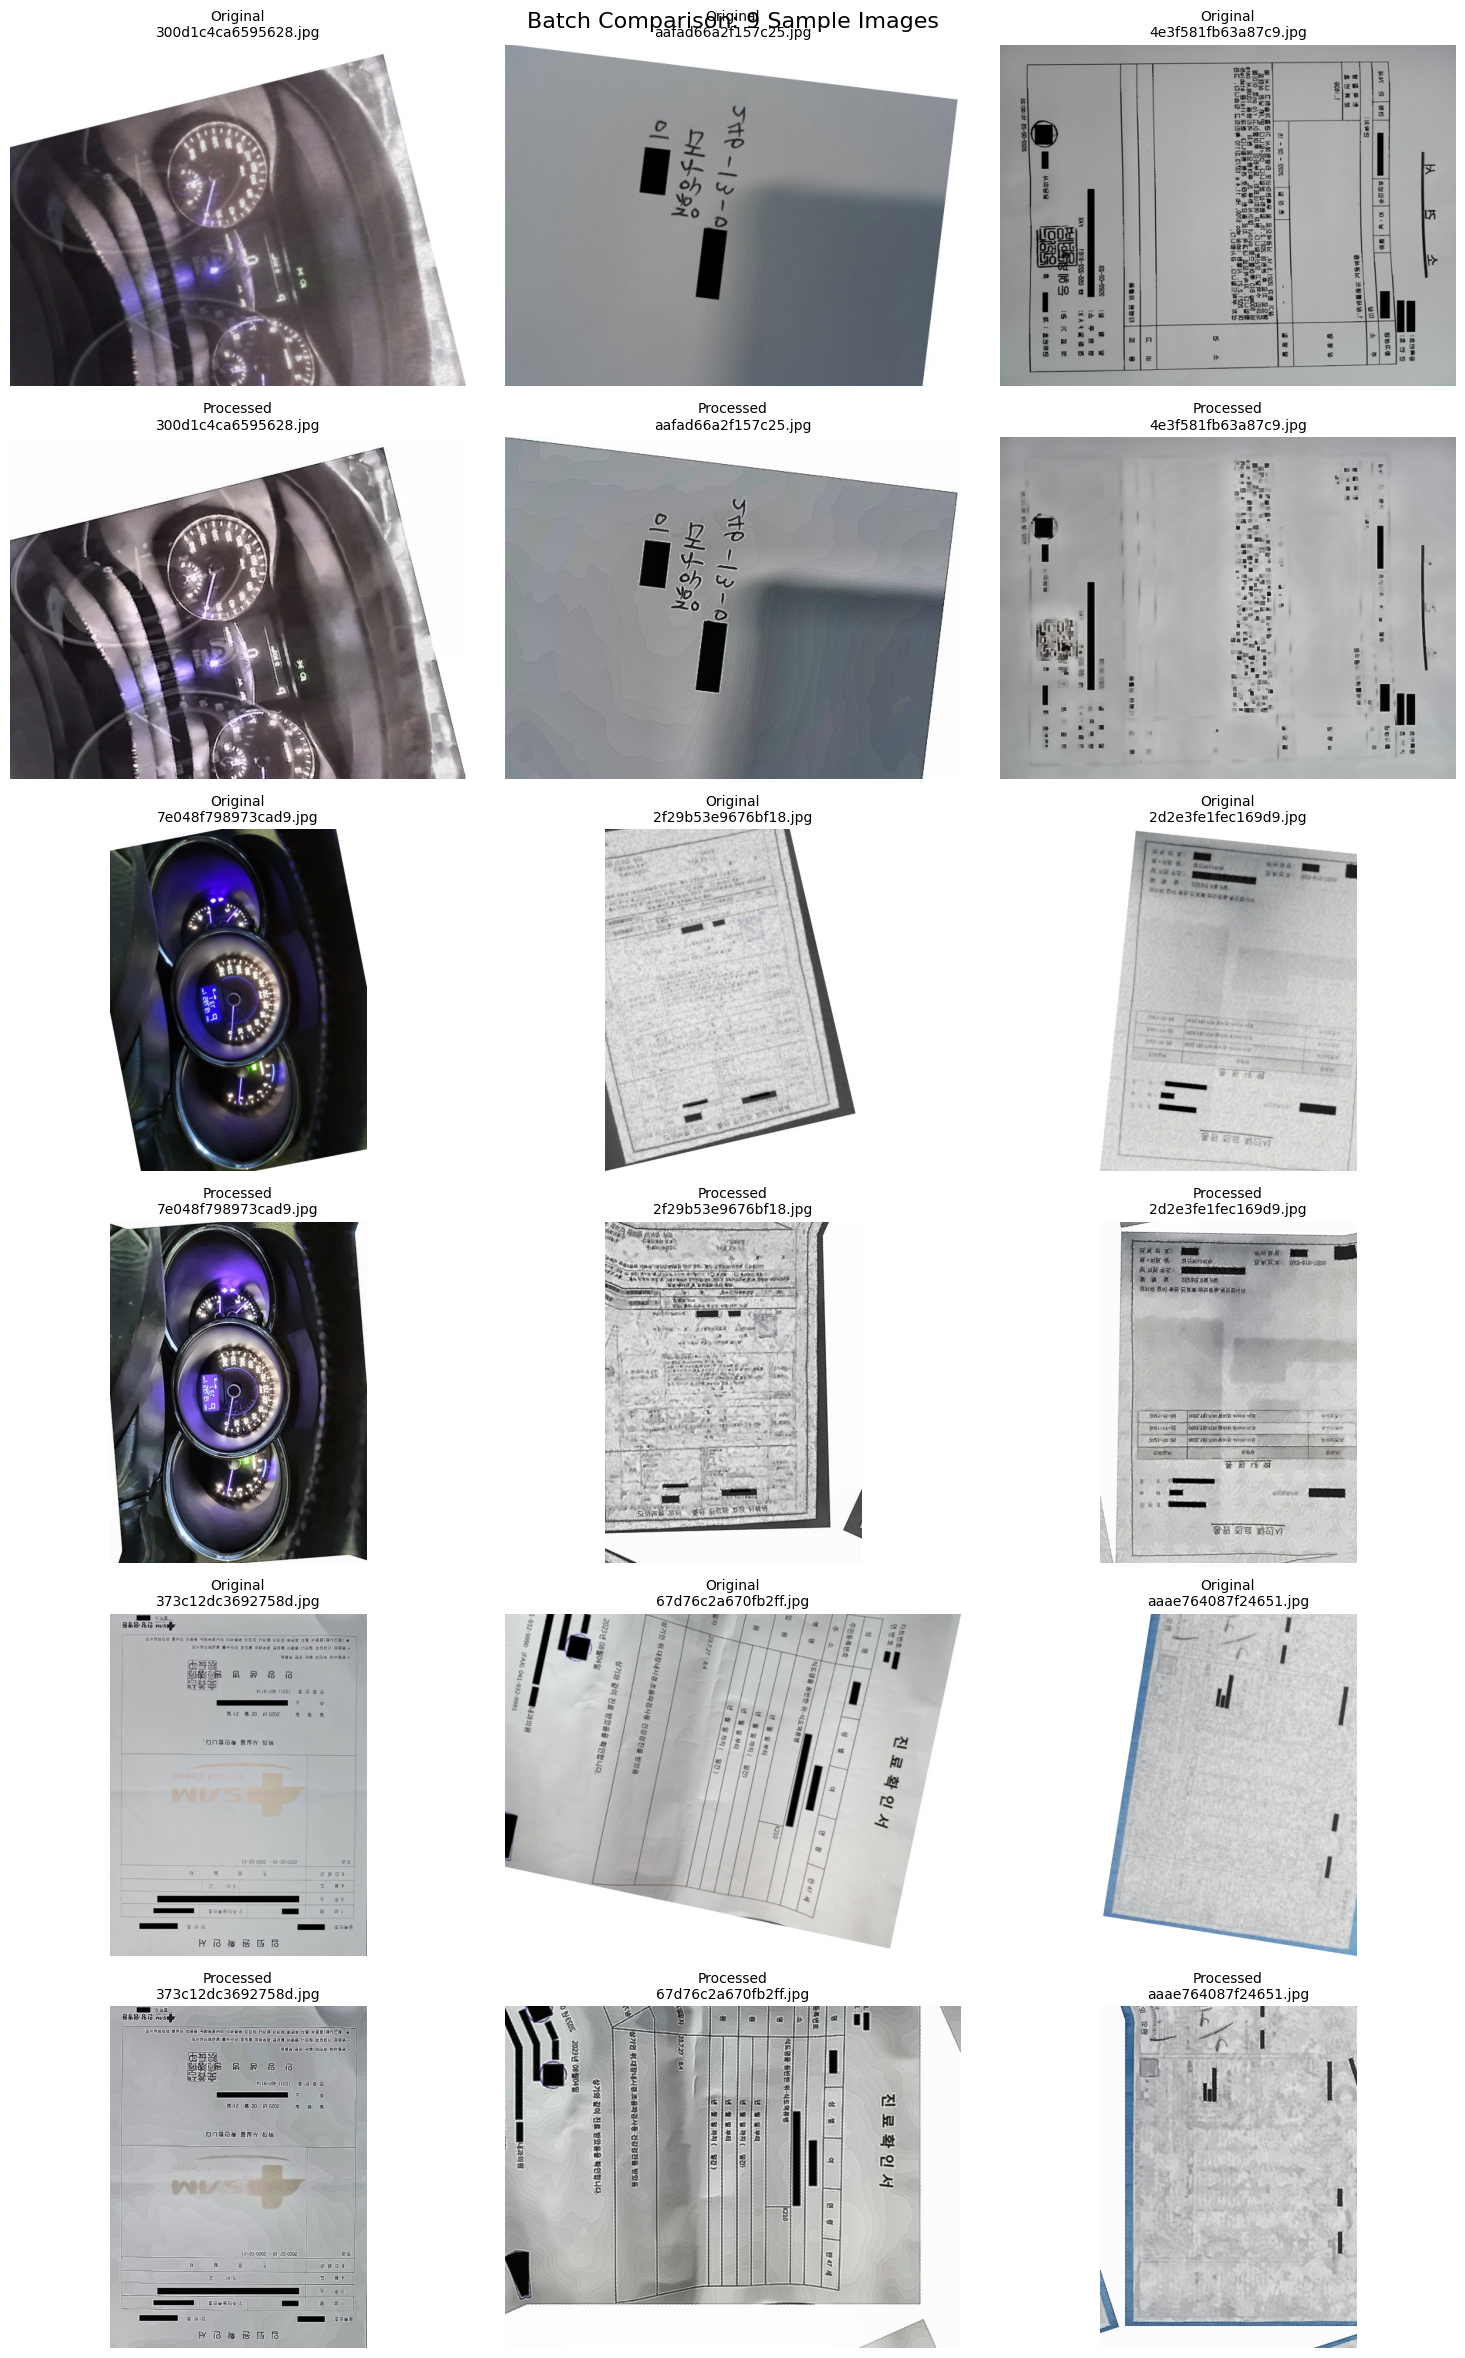

✅ 그리드 비교 완료: 9개 이미지

📋 비교 메뉴:
1. 단일 이미지 상세 비교
2. 랜덤 샘플 그리드 비교 (9개)
3. 배치 개선도 분석
4. 종료


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont

그리드 비교 저장: grid_comparison_20250909_092633.png


findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'Arial Unicode MS' not found.
findfont

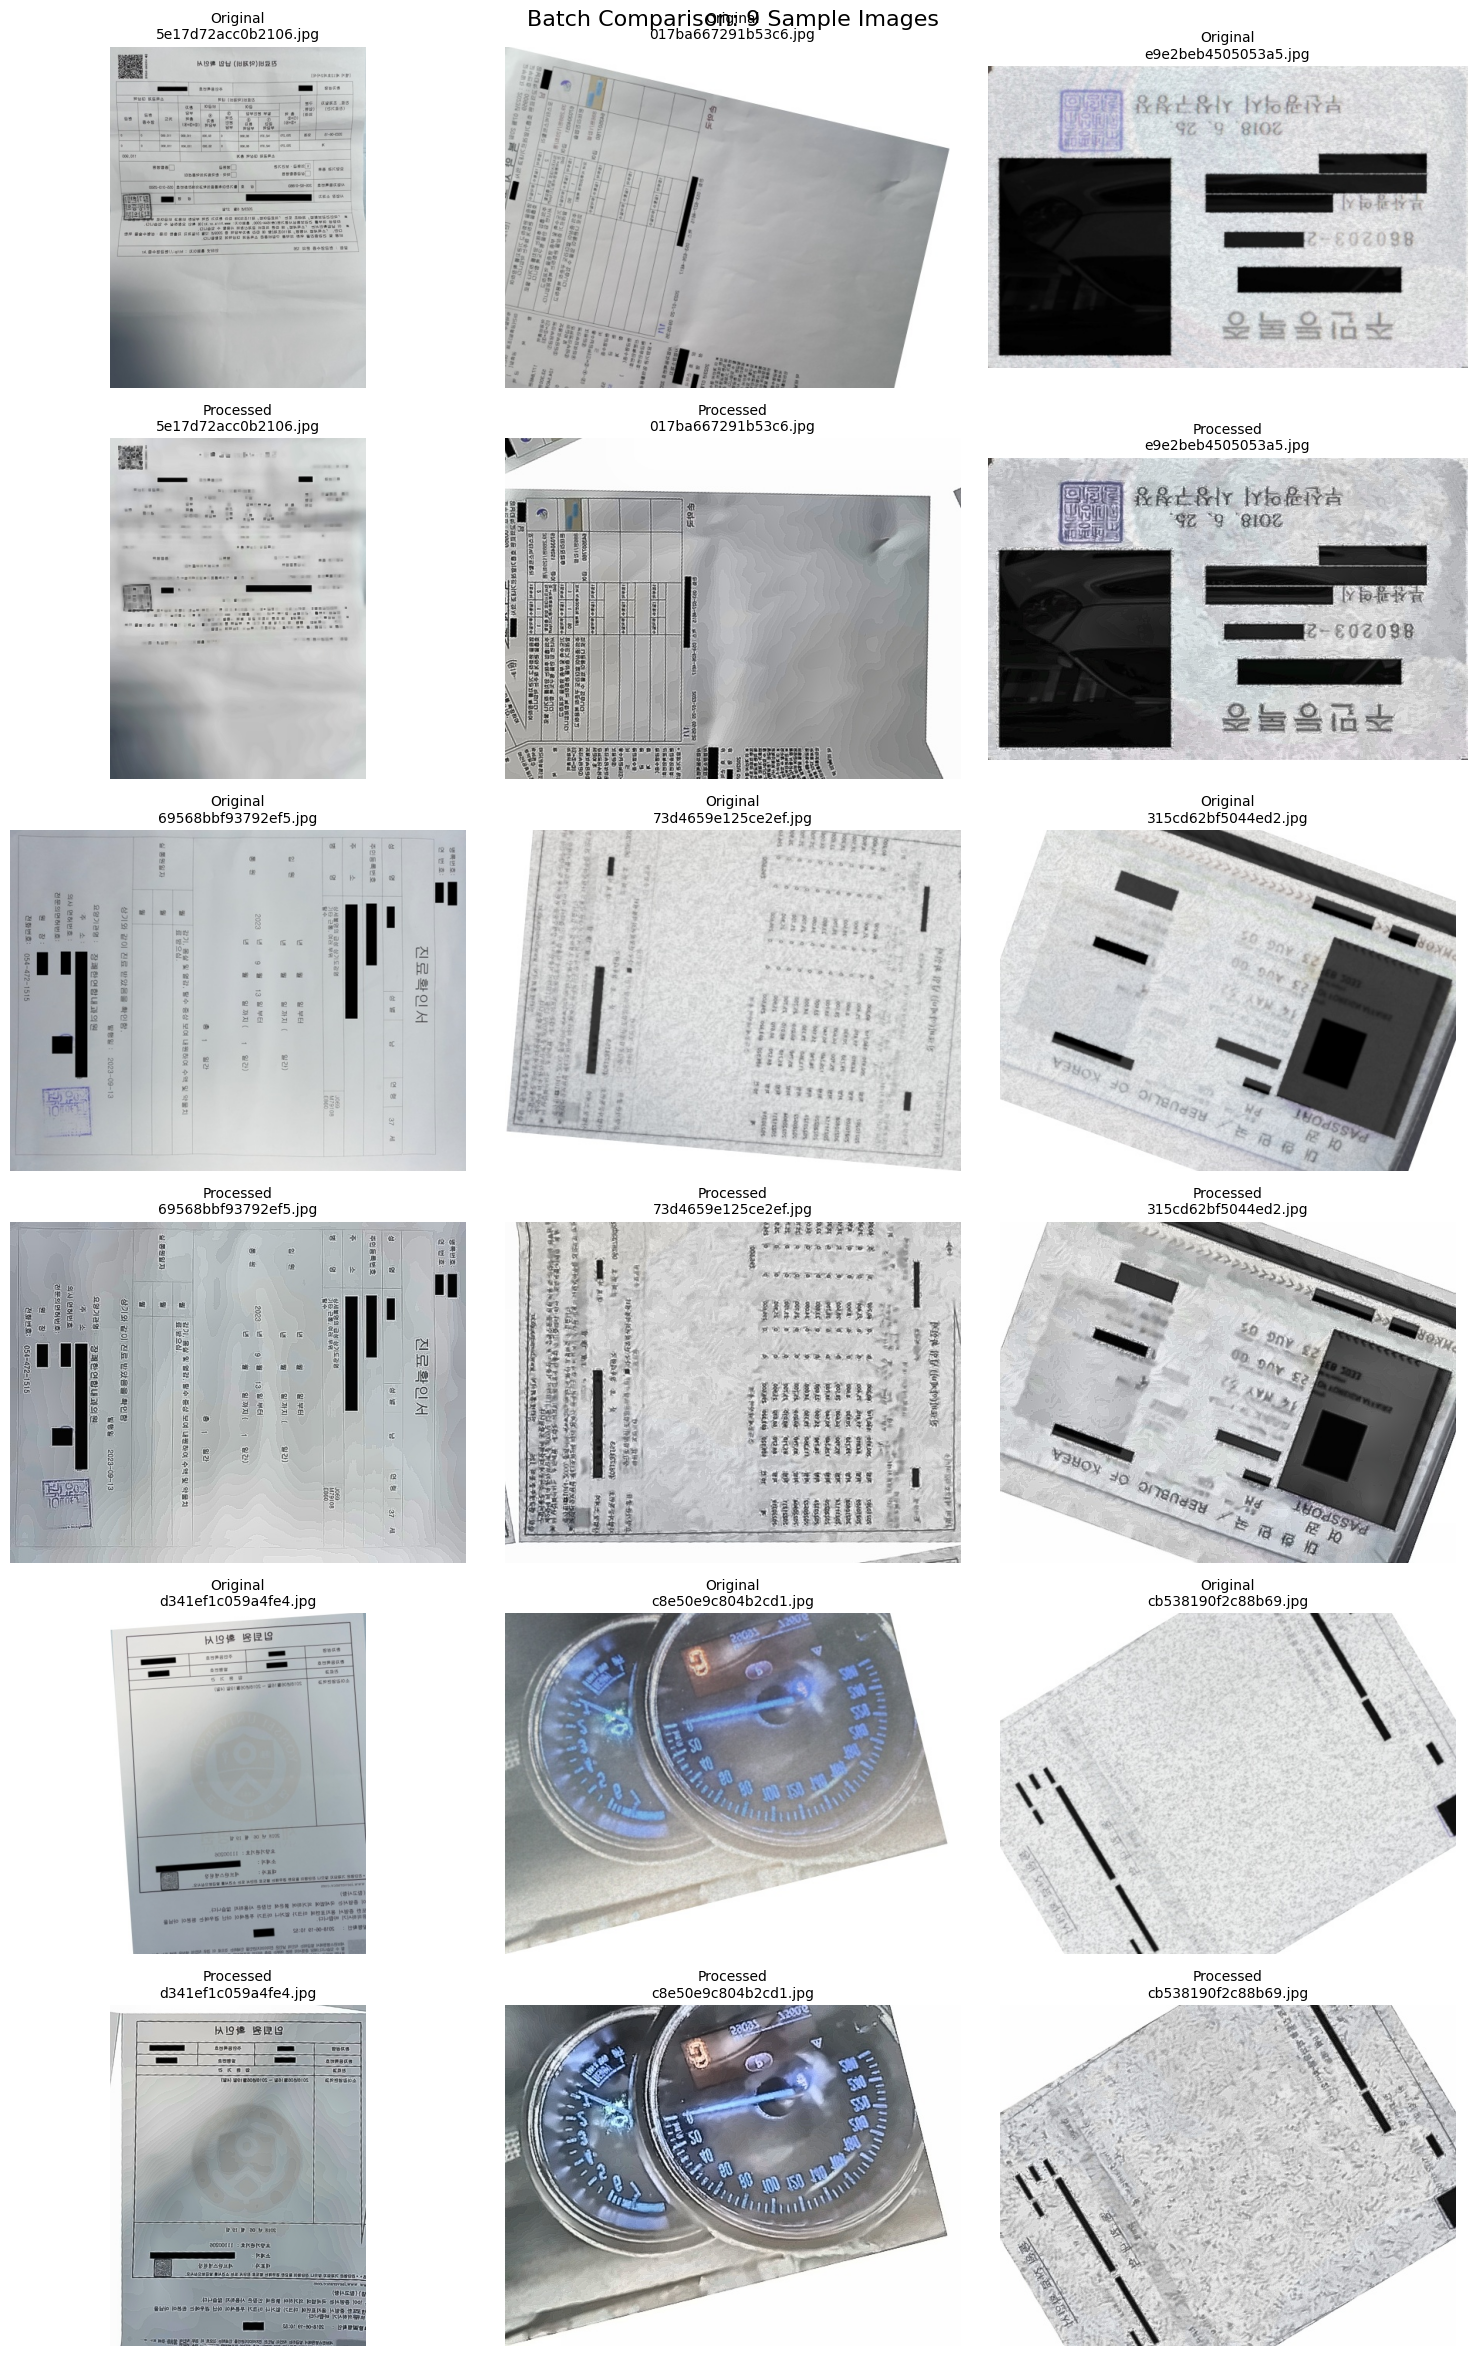

✅ 그리드 비교 완료: 9개 이미지

📋 비교 메뉴:
1. 단일 이미지 상세 비교
2. 랜덤 샘플 그리드 비교 (9개)
3. 배치 개선도 분석
4. 종료
프로그램을 종료합니다.


In [ ]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import warnings
import random
import json
from datetime import datetime
warnings.filterwarnings('ignore')

class ImageComparisonTool:
    """전처리 전후 이미지 비교 도구"""
    
    def __init__(self):
        # matplotlib 한글 폰트 설정 (가능한 경우)
        try:
            plt.rcParams['font.family'] = ['DejaVu Sans', 'Arial Unicode MS', 'SimHei']
        except:
            pass
    
    def calculate_image_metrics(self, image):
        """이미지 품질 메트릭 계산"""
        try:
            if len(image.shape) == 3:
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            else:
                gray = image.copy()
            
            # 선명도 (라플라시안 분산)
            sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
            
            # 대비 (표준편차)
            contrast = gray.std()
            
            # 밝기 (평균)
            brightness = gray.mean()
            
            # 엣지 밀도
            edges = cv2.Canny(gray, 50, 150)
            edge_density = np.sum(edges > 0) / edges.size
            
            # 노이즈 추정
            blurred = cv2.GaussianBlur(gray, (5, 5), 0)
            noise = gray.astype(np.float32) - blurred.astype(np.float32)
            noise_level = np.std(noise)
            
            return {
                'sharpness': sharpness,
                'contrast': contrast,
                'brightness': brightness,
                'edge_density': edge_density,
                'noise_level': noise_level
            }
        except Exception as e:
            print(f"메트릭 계산 오류: {e}")
            return None
    
    def compare_single_image(self, original_path, processed_path, save_path=None, show_metrics=True):
        """단일 이미지 비교"""
        try:
            # 이미지 로드
            original = cv2.imread(original_path)
            processed = cv2.imread(processed_path)
            
            if original is None or processed is None:
                print(f"이미지 로드 실패: {original_path} 또는 {processed_path}")
                return None
            
            # RGB로 변환 (matplotlib 표시용)
            original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
            processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
            
            # 메트릭 계산
            original_metrics = self.calculate_image_metrics(original)
            processed_metrics = self.calculate_image_metrics(processed)
            
            if original_metrics is None or processed_metrics is None:
                return None
            
            # 시각화
            fig = plt.figure(figsize=(16, 10))
            gs = GridSpec(3, 4, figure=fig, height_ratios=[2, 2, 1], width_ratios=[1, 1, 1, 1])
            
            # 원본 이미지
            ax1 = fig.add_subplot(gs[0, :2])
            ax1.imshow(original_rgb)
            ax1.set_title(f'Original Image\n{os.path.basename(original_path)}', fontsize=12)
            ax1.axis('off')
            
            # 전처리된 이미지
            ax2 = fig.add_subplot(gs[0, 2:])
            ax2.imshow(processed_rgb)
            ax2.set_title(f'Processed Image\n{os.path.basename(processed_path)}', fontsize=12)
            ax2.axis('off')
            
            if show_metrics and original_metrics and processed_metrics:
                # 히스토그램 비교
                ax3 = fig.add_subplot(gs[1, :2])
                orig_gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
                proc_gray = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
                
                ax3.hist(orig_gray.flatten(), bins=50, alpha=0.6, label='Original', color='red', density=True)
                ax3.hist(proc_gray.flatten(), bins=50, alpha=0.6, label='Processed', color='blue', density=True)
                ax3.set_title('Pixel Intensity Distribution')
                ax3.set_xlabel('Pixel Intensity')
                ax3.set_ylabel('Density')
                ax3.legend()
                ax3.grid(True, alpha=0.3)
                
                # 메트릭 비교
                ax4 = fig.add_subplot(gs[1, 2:])
                metrics_names = list(original_metrics.keys())
                orig_values = [original_metrics[key] for key in metrics_names]
                proc_values = [processed_metrics[key] for key in metrics_names]
                
                x = np.arange(len(metrics_names))
                width = 0.35
                
                bars1 = ax4.bar(x - width/2, orig_values, width, label='Original', alpha=0.8, color='red')
                bars2 = ax4.bar(x + width/2, proc_values, width, label='Processed', alpha=0.8, color='blue')
                
                ax4.set_xlabel('Metrics')
                ax4.set_ylabel('Values')
                ax4.set_title('Quality Metrics Comparison')
                ax4.set_xticks(x)
                ax4.set_xticklabels([name.replace('_', '\n') for name in metrics_names], fontsize=9)
                ax4.legend()
                ax4.grid(True, alpha=0.3)
                
                # 개선도 계산 및 표시
                improvements = {}
                for key in metrics_names:
                    if original_metrics[key] != 0:
                        improvement = ((processed_metrics[key] - original_metrics[key]) / abs(original_metrics[key])) * 100
                    else:
                        improvement = 0
                    improvements[key] = improvement
                
                # 요약 텍스트
                ax5 = fig.add_subplot(gs[2, :])
                ax5.axis('off')
                
                summary_text = f"Image Comparison Summary:\n"
                summary_text += f"Original: {original.shape[1]}x{original.shape[0]} | "
                summary_text += f"Processed: {processed.shape[1]}x{processed.shape[0]}\n\n"
                
                for key, improvement in improvements.items():
                    status = "↗" if improvement > 1 else "↘" if improvement < -1 else "→"
                    summary_text += f"{key.replace('_', ' ').title()}: {improvement:+.1f}% {status}  "
                
                overall_improvement = np.mean(list(improvements.values()))
                summary_text += f"\n\nOverall Improvement: {overall_improvement:+.1f}%\n"
                
                if overall_improvement > 5:
                    summary_text += "✅ 전처리가 효과적입니다!"
                elif overall_improvement > 0:
                    summary_text += "⚡ 전처리가 약간의 개선을 보입니다."
                else:
                    summary_text += "⚠️ 전처리 효과가 제한적입니다."
                
                ax5.text(0.05, 0.95, summary_text, transform=ax5.transAxes, fontsize=11,
                        verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))
            
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"비교 결과 저장: {save_path}")
            
            plt.show()
            
            return {
                'original_metrics': original_metrics,
                'processed_metrics': processed_metrics,
                'improvements': improvements if show_metrics else None
            }
            
        except Exception as e:
            print(f"이미지 비교 중 오류: {e}")
            return None
    
    def create_batch_comparison_grid(self, original_dir, processed_dir, num_samples=9, save_path=None):
        """배치 이미지 그리드 비교"""
        try:
            # 공통 이미지 파일 찾기
            original_files = set([f for f in os.listdir(original_dir) 
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            processed_files = set([f for f in os.listdir(processed_dir) 
                                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            
            common_files = list(original_files.intersection(processed_files))
            
            if not common_files:
                print("공통 이미지 파일을 찾을 수 없습니다.")
                return None
            
            # 샘플 선택
            sample_files = random.sample(common_files, min(num_samples, len(common_files)))
            
            # 그리드 크기 계산
            rows = int(np.ceil(len(sample_files) / 3))
            cols = min(3, len(sample_files))
            
            fig, axes = plt.subplots(rows * 2, cols, figsize=(cols * 5, rows * 8))
            if len(sample_files) == 1:
                axes = np.array([[axes[0]], [axes[1]]])
            elif rows == 1:
                axes = axes.reshape(2, -1)
            
            for i, img_file in enumerate(sample_files):
                row = i // cols
                col = i % cols
                
                # 이미지 로드
                original_path = os.path.join(original_dir, img_file)
                processed_path = os.path.join(processed_dir, img_file)
                
                original = cv2.imread(original_path)
                processed = cv2.imread(processed_path)
                
                if original is None or processed is None:
                    continue
                
                # RGB 변환
                original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
                processed_rgb = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
                
                # 원본 이미지
                axes[row * 2, col].imshow(original_rgb)
                axes[row * 2, col].set_title(f'Original\n{img_file}', fontsize=10)
                axes[row * 2, col].axis('off')
                
                # 전처리된 이미지
                axes[row * 2 + 1, col].imshow(processed_rgb)
                axes[row * 2 + 1, col].set_title(f'Processed\n{img_file}', fontsize=10)
                axes[row * 2 + 1, col].axis('off')
            
            # 빈 subplot 숨기기
            for i in range(len(sample_files), rows * cols):
                row = i // cols
                col = i % cols
                axes[row * 2, col].axis('off')
                axes[row * 2 + 1, col].axis('off')
            
            plt.suptitle(f'Batch Comparison: {len(sample_files)} Sample Images', fontsize=16)
            plt.tight_layout()
            
            if save_path:
                plt.savefig(save_path, dpi=300, bbox_inches='tight')
                print(f"그리드 비교 저장: {save_path}")
            
            plt.show()
            
            return sample_files
            
        except Exception as e:
            print(f"배치 비교 중 오류: {e}")
            return None
    
    def analyze_batch_improvements(self, original_dir, processed_dir, sample_size=50):
        """배치 이미지 개선도 분석"""
        try:
            # 공통 이미지 파일 찾기
            original_files = set([f for f in os.listdir(original_dir) 
                                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            processed_files = set([f for f in os.listdir(processed_dir) 
                                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
            
            common_files = list(original_files.intersection(processed_files))
            
            if not common_files:
                print("공통 이미지 파일을 찾을 수 없습니다.")
                return None
            
            # 샘플 선택
            sample_files = random.sample(common_files, min(sample_size, len(common_files)))
            
            all_improvements = {
                'sharpness': [],
                'contrast': [],
                'brightness': [],
                'edge_density': [],
                'noise_level': []
            }
            
            successful_comparisons = 0
            
            print(f"배치 분석 중: {len(sample_files)}개 이미지...")
            
            for img_file in sample_files:
                original_path = os.path.join(original_dir, img_file)
                processed_path = os.path.join(processed_dir, img_file)
                
                original = cv2.imread(original_path)
                processed = cv2.imread(processed_path)
                
                if original is None or processed is None:
                    continue
                
                original_metrics = self.calculate_image_metrics(original)
                processed_metrics = self.calculate_image_metrics(processed)
                
                if original_metrics is None or processed_metrics is None:
                    continue
                
                # 개선도 계산
                for key in all_improvements.keys():
                    if original_metrics[key] != 0:
                        improvement = ((processed_metrics[key] - original_metrics[key]) / abs(original_metrics[key])) * 100
                    else:
                        improvement = 0
                    all_improvements[key].append(improvement)
                
                successful_comparisons += 1
            
            if successful_comparisons == 0:
                print("성공적으로 분석된 이미지가 없습니다.")
                return None
            
            # 결과 시각화
            fig, axes = plt.subplots(2, 3, figsize=(18, 10))
            
            # 각 메트릭별 히스토그램
            for i, (metric, improvements) in enumerate(all_improvements.items()):
                if i < 5:
                    row = i // 3
                    col = i % 3
                    ax = axes[row, col]
                    
                    ax.hist(improvements, bins=20, alpha=0.7, edgecolor='black')
                    ax.set_title(f'{metric.replace("_", " ").title()} Improvement')
                    ax.set_xlabel('Improvement (%)')
                    ax.set_ylabel('Frequency')
                    ax.axvline(np.mean(improvements), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(improvements):.1f}%')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
            
            # 전체 요약
            ax_summary = axes[1, 2]
            ax_summary.axis('off')
            
            summary_text = f"Batch Analysis Summary\n({successful_comparisons} images)\n\n"
            for metric, improvements in all_improvements.items():
                mean_imp = np.mean(improvements)
                std_imp = np.std(improvements)
                summary_text += f"{metric.replace('_', ' ').title()}:\n"
                summary_text += f"  {mean_imp:+.1f}% ± {std_imp:.1f}%\n\n"
            
            overall = np.mean([np.mean(vals) for vals in all_improvements.values()])
            summary_text += f"Overall: {overall:+.1f}%\n\n"
            
            if overall > 3:
                summary_text += "✅ 효과적인 전처리!"
            elif overall > 0:
                summary_text += "⚡ 약간의 개선"
            else:
                summary_text += "⚠️ 제한적인 효과"
            
            ax_summary.text(0.05, 0.95, summary_text, transform=ax_summary.transAxes,
                           fontsize=11, verticalalignment='top', fontfamily='monospace',
                           bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen"))
            
            plt.tight_layout()
            plt.show()
            
            return {
                'improvements': all_improvements,
                'successful_comparisons': successful_comparisons,
                'overall_improvement': overall
            }
            
        except Exception as e:
            print(f"배치 분석 중 오류: {e}")
            return None

def main():
    """메인 실행 함수"""
    
    ORIGINAL_DIR = "/root/home/cv_contest/CV_data/test"  # 원본 이미지
    PROCESSED_DIR = "/root/home/cv_contest/test_preprocessing_complete"  # 전처리된 이미지
    
    print("🔍 이미지 전처리 비교 도구")
    print("=" * 50)
    
    # 디렉토리 확인
    if not os.path.exists(ORIGINAL_DIR):
        print(f"❌ 원본 디렉토리가 존재하지 않습니다: {ORIGINAL_DIR}")
        return
    
    if not os.path.exists(PROCESSED_DIR):
        print(f"❌ 전처리된 디렉토리가 존재하지 않습니다: {PROCESSED_DIR}")
        return
    
    # 공통 이미지 파일 확인
    original_files = set([f for f in os.listdir(ORIGINAL_DIR) 
                         if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    processed_files = set([f for f in os.listdir(PROCESSED_DIR) 
                          if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    
    common_files = original_files.intersection(processed_files)
    
    print(f"📊 원본 이미지: {len(original_files)}개")
    print(f"📊 전처리된 이미지: {len(processed_files)}개")
    print(f"📊 비교 가능한 이미지: {len(common_files)}개")
    
    if len(common_files) == 0:
        print("❌ 비교할 수 있는 공통 이미지가 없습니다.")
        return
    
    # 비교 도구 초기화
    comparator = ImageComparisonTool()
    
    # 사용자 메뉴
    while True:
        print("\n📋 비교 메뉴:")
        print("1. 단일 이미지 상세 비교")
        print("2. 랜덤 샘플 그리드 비교 (9개)")
        print("3. 배치 개선도 분석")
        print("4. 종료")
        
        choice = input("선택 (1-4): ").strip()
        
        if choice == "1":
            # 단일 이미지 비교
            print(f"\n사용 가능한 이미지 (처음 10개):")
            sample_list = list(common_files)[:10]
            for i, img_file in enumerate(sample_list):
                print(f"  {i+1}. {img_file}")
            
            try:
                img_choice = input("이미지 번호 선택 (1-10) 또는 파일명 입력: ").strip()
                
                if img_choice.isdigit():
                    img_idx = int(img_choice) - 1
                    if 0 <= img_idx < len(sample_list):
                        selected_file = sample_list[img_idx]
                    else:
                        print("잘못된 번호입니다.")
                        continue
                else:
                    selected_file = img_choice
                    if selected_file not in common_files:
                        print("해당 파일이 없습니다.")
                        continue
                
                original_path = os.path.join(ORIGINAL_DIR, selected_file)
                processed_path = os.path.join(PROCESSED_DIR, selected_file)
                save_path = f"comparison_{selected_file.split('.')[0]}.png"
                
                result = comparator.compare_single_image(original_path, processed_path, save_path)
                
                if result:
                    print("✅ 단일 이미지 비교 완료")
                
            except Exception as e:
                print(f"오류: {e}")
        
        elif choice == "2":
            # 그리드 비교
            save_path = f"grid_comparison_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
            sample_files = comparator.create_batch_comparison_grid(ORIGINAL_DIR, PROCESSED_DIR, 20, save_path)
            
            if sample_files:
                print(f"✅ 그리드 비교 완료: {len(sample_files)}개 이미지")
        
        elif choice == "3":
            # 배치 분석
            sample_size = input("분석할 샘플 크기 (기본 50): ").strip()
            sample_size = int(sample_size) if sample_size.isdigit() else 50
            
            result = comparator.analyze_batch_improvements(ORIGINAL_DIR, PROCESSED_DIR, sample_size)
            
            if result:
                print(f"✅ 배치 분석 완료: {result['successful_comparisons']}개 이미지 분석")
                print(f"전체 개선도: {result['overall_improvement']:+.1f}%")
        
        elif choice == "4":
            print("프로그램을 종료합니다.")
            break
        
        else:
            print("잘못된 선택입니다.")

if __name__ == "__main__":
    main()